## public submit

* 당진태양광 : dangjin
* 당진수상태양광 : dangjin_floating
* 당진자재창고태양광 : dangjin_warehouse
* 울산태양광 : ulsan

기상청 데이터 경로 및 파일 이름 : /new_data
* 당진 데이터 dangjin_fcst_h2320.csv
* 울산 데이터 ulsan_fcst_h2320.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


def get_dircat(x):
    if x < 90:
        return 1
    elif (x >= 90)&(x < 180):
        return 2
    elif (x >= 180)&(x < 270):
        return 3
    else:
        return 4
    

def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['Forecast_time2'] = pd.to_datetime(test_df['Forecast_time'])
    test_df['hour'] = test_df['Forecast_time2'].dt.hour
    test_df['year'] = test_df['Forecast_time2'].dt.year
    test_df['month'] = test_df['Forecast_time2'].dt.month
    test_df['day'] = test_df['Forecast_time2'].dt.day
    test_df['day_name'] = test_df['Forecast_time2'].dt.day_name()
    test_df['WindDirection'] = test_df['WindDirection'].apply(get_dircat)
    test_df['PP'] = test_df['PrecipitationProb']*test_df['PrecipitationForm']
    test_df['WW'] = test_df['WindSpeed']*test_df['WindDirection']
    test_df['HT'] = test_df['Humidity']*test_df['Temperature']

    test_df = test_df[['month', 'day', 'day_name', 'hour','Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', 'PP','WW','HT']]
    test_df = pd.get_dummies(test_df, columns = ['hour','WindDirection','day_name'])                  
  
    return test_df


dangjin_fcst = pd.read_csv('./new_data/dangjin_fcst_h2320.csv') 
ulsan_fcst = pd.read_csv('./new_data/ulsan_fcst_h2320.csv')

dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

In [2]:
dangjin_floating_model = load_model('./models/dangjin_floating_model.h5')
dangjin_warehouse_model = load_model('./models/dangjin_warehouse_model.h5')
dangjin_model = load_model('./models/dangjin_model.h5')
ulsan_model = load_model('./models/ulsan_model.h5')

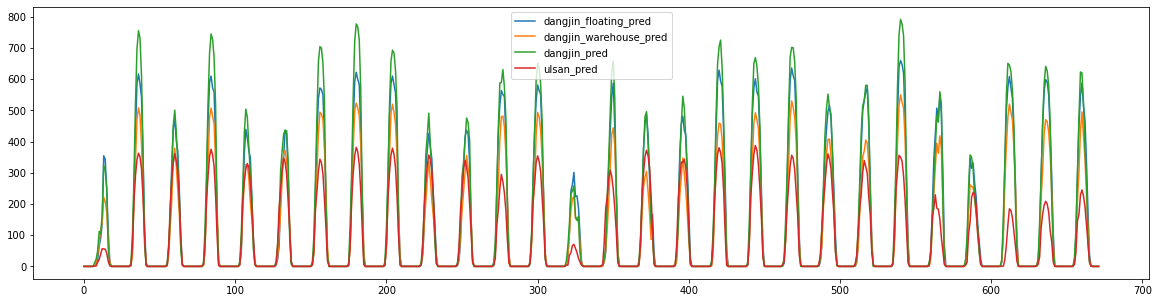

In [3]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [4]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.014188,0.011548,0.003231,-0.009335
1,2021-02-01 02:00:00,0.016915,0.009535,-0.001077,-0.052690
2,2021-02-01 03:00:00,0.019181,0.008932,0.023614,-0.056899
3,2021-02-01 04:00:00,0.017508,0.011123,-0.000475,-0.007528
4,2021-02-01 05:00:00,0.019321,0.009098,-0.002396,0.010660
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [5]:
submission.to_csv('./submit/public_submit.csv', index=False)